In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats
from matplotlib import container

In [3]:
summary_df = pd.read_csv("aggregate_summary_all.csv", index_col=0)
molecules = summary_df["molecule"]
molecule_set = set(molecules)
group_key = "molecule"


In [4]:
plt.rcParams["font.family"] = "times" # "helvetica"
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'


# Data cleaning and intial set up

In [5]:
summary_df = summary_df[summary_df["pressure"] != 3000]

In [6]:
def mean_confidence_interval(m,se, confidence=0.95):  
    se = np.array(se)
    n = 16
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

In [7]:
from pprint import pprint

def data_cleaning(molecule_set):
    """Make sure properties of all molecule in the provided molecule_set has been calculated."""
    for molecule in molecule_set:
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
        mol_df["statepoint"] = (
            summary_df["temperature"].map(str)
            + "K, "
            + summary_df["pressure"].map(str)
            + "kPa, "
            + summary_df["ensemble"]
        )
        sp_set = set(mol_df["statepoint"])
        goods = list()
        bads = list()
        for engine in mol_df["engine"].unique():
            found_sp = mol_df[mol_df["engine"] == engine].index.tolist()
            if len(found_sp) == len(set(mol_df["statepoint"])):
                goods.append((engine, found_sp))
            else:
                mol_df.drop(axis=0, labels=found_sp, inplace=True)
                bads.append((engine, found_sp))

        if goods:
            print(f"\tPassed: {[good[0] for good in goods]}")
        if bads:
            print(f"\tFailed: {[bad[0] for bad in bads]}")
data_cleaning(molecule_set)

	Passed: ['lammps-VU', 'mcccs']


# Style set up

In [8]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)


In [9]:
molecules = ("ethanolAA",)
engines = ("lammps-VU", "mcccs",)


# Colors
symbols = {}
symbols[ "mcccs"] = "^"
symbols[ "lammps-VU"] = "D"
#symbols[ "LAMMPS-UD"] = ">"

colors = {}
colors["mcccs"] = "#39B1B5" #(194/256, 135/256, 32/256)
colors["lammps-VU"] = "#E88471" #(188/256, 146/256, 110/256)
colors["fix"] = "#FF7F00"
colors["flex"] = "#007FFF"
pretty_names = {
    "mcccsflex": "MCCCS-MN-flex", 
    "mcccsfix": "MCCCS-MN-fix", 
    "lammps-VUflex": "LAMMPS-flex",
    "lammps-VUfix": "LAMMPS-fixOH",
}

fill_styles = {
    "mcccs": "none", 
    "lammps-VU": "full",
}


In [10]:
import itertools

# Stack plots

lammps-VU fix
812.4275791468947 0.09173614131593145
-0.18507519676482168 0.011270710500502405
lammps-VU flex
815.5830003418517 0.27167368653273777
0.2026001325585637 0.03337785334756573
mcccs fix
813.008969577506 0.3666787222912424
-0.11364551662800326 0.04505018051070996
mcccs flex
814.7163271002846 0.4707973855198998
0.09612058083428918 0.05784220875733197
lammps-VU fix
791.2744706330061 0.18690419837645766
-0.18831985709432178 0.0235761707954426
lammps-VU flex
795.1182106955572 0.18157971615700982
0.29653106115773337 0.02290453846565321
mcccs fix
791.4405065361314 0.2265039414176146
-0.16737602145949057 0.028571298318011685
mcccs flex
793.2364484748454 0.3471201491693231
0.059164817396021634 0.043785875301056355
lammps-VU fix
768.6390996325476 0.1576903134101689
-0.26491018121350557 0.020461172973160347
lammps-VU flex
774.21413411656 0.292045420340331
0.45848076425311896 0.037894476409972615
mcccs fix
768.7353597509236 0.2853686108028356
-0.252419909047041 0.03702812417881059
mcccs 

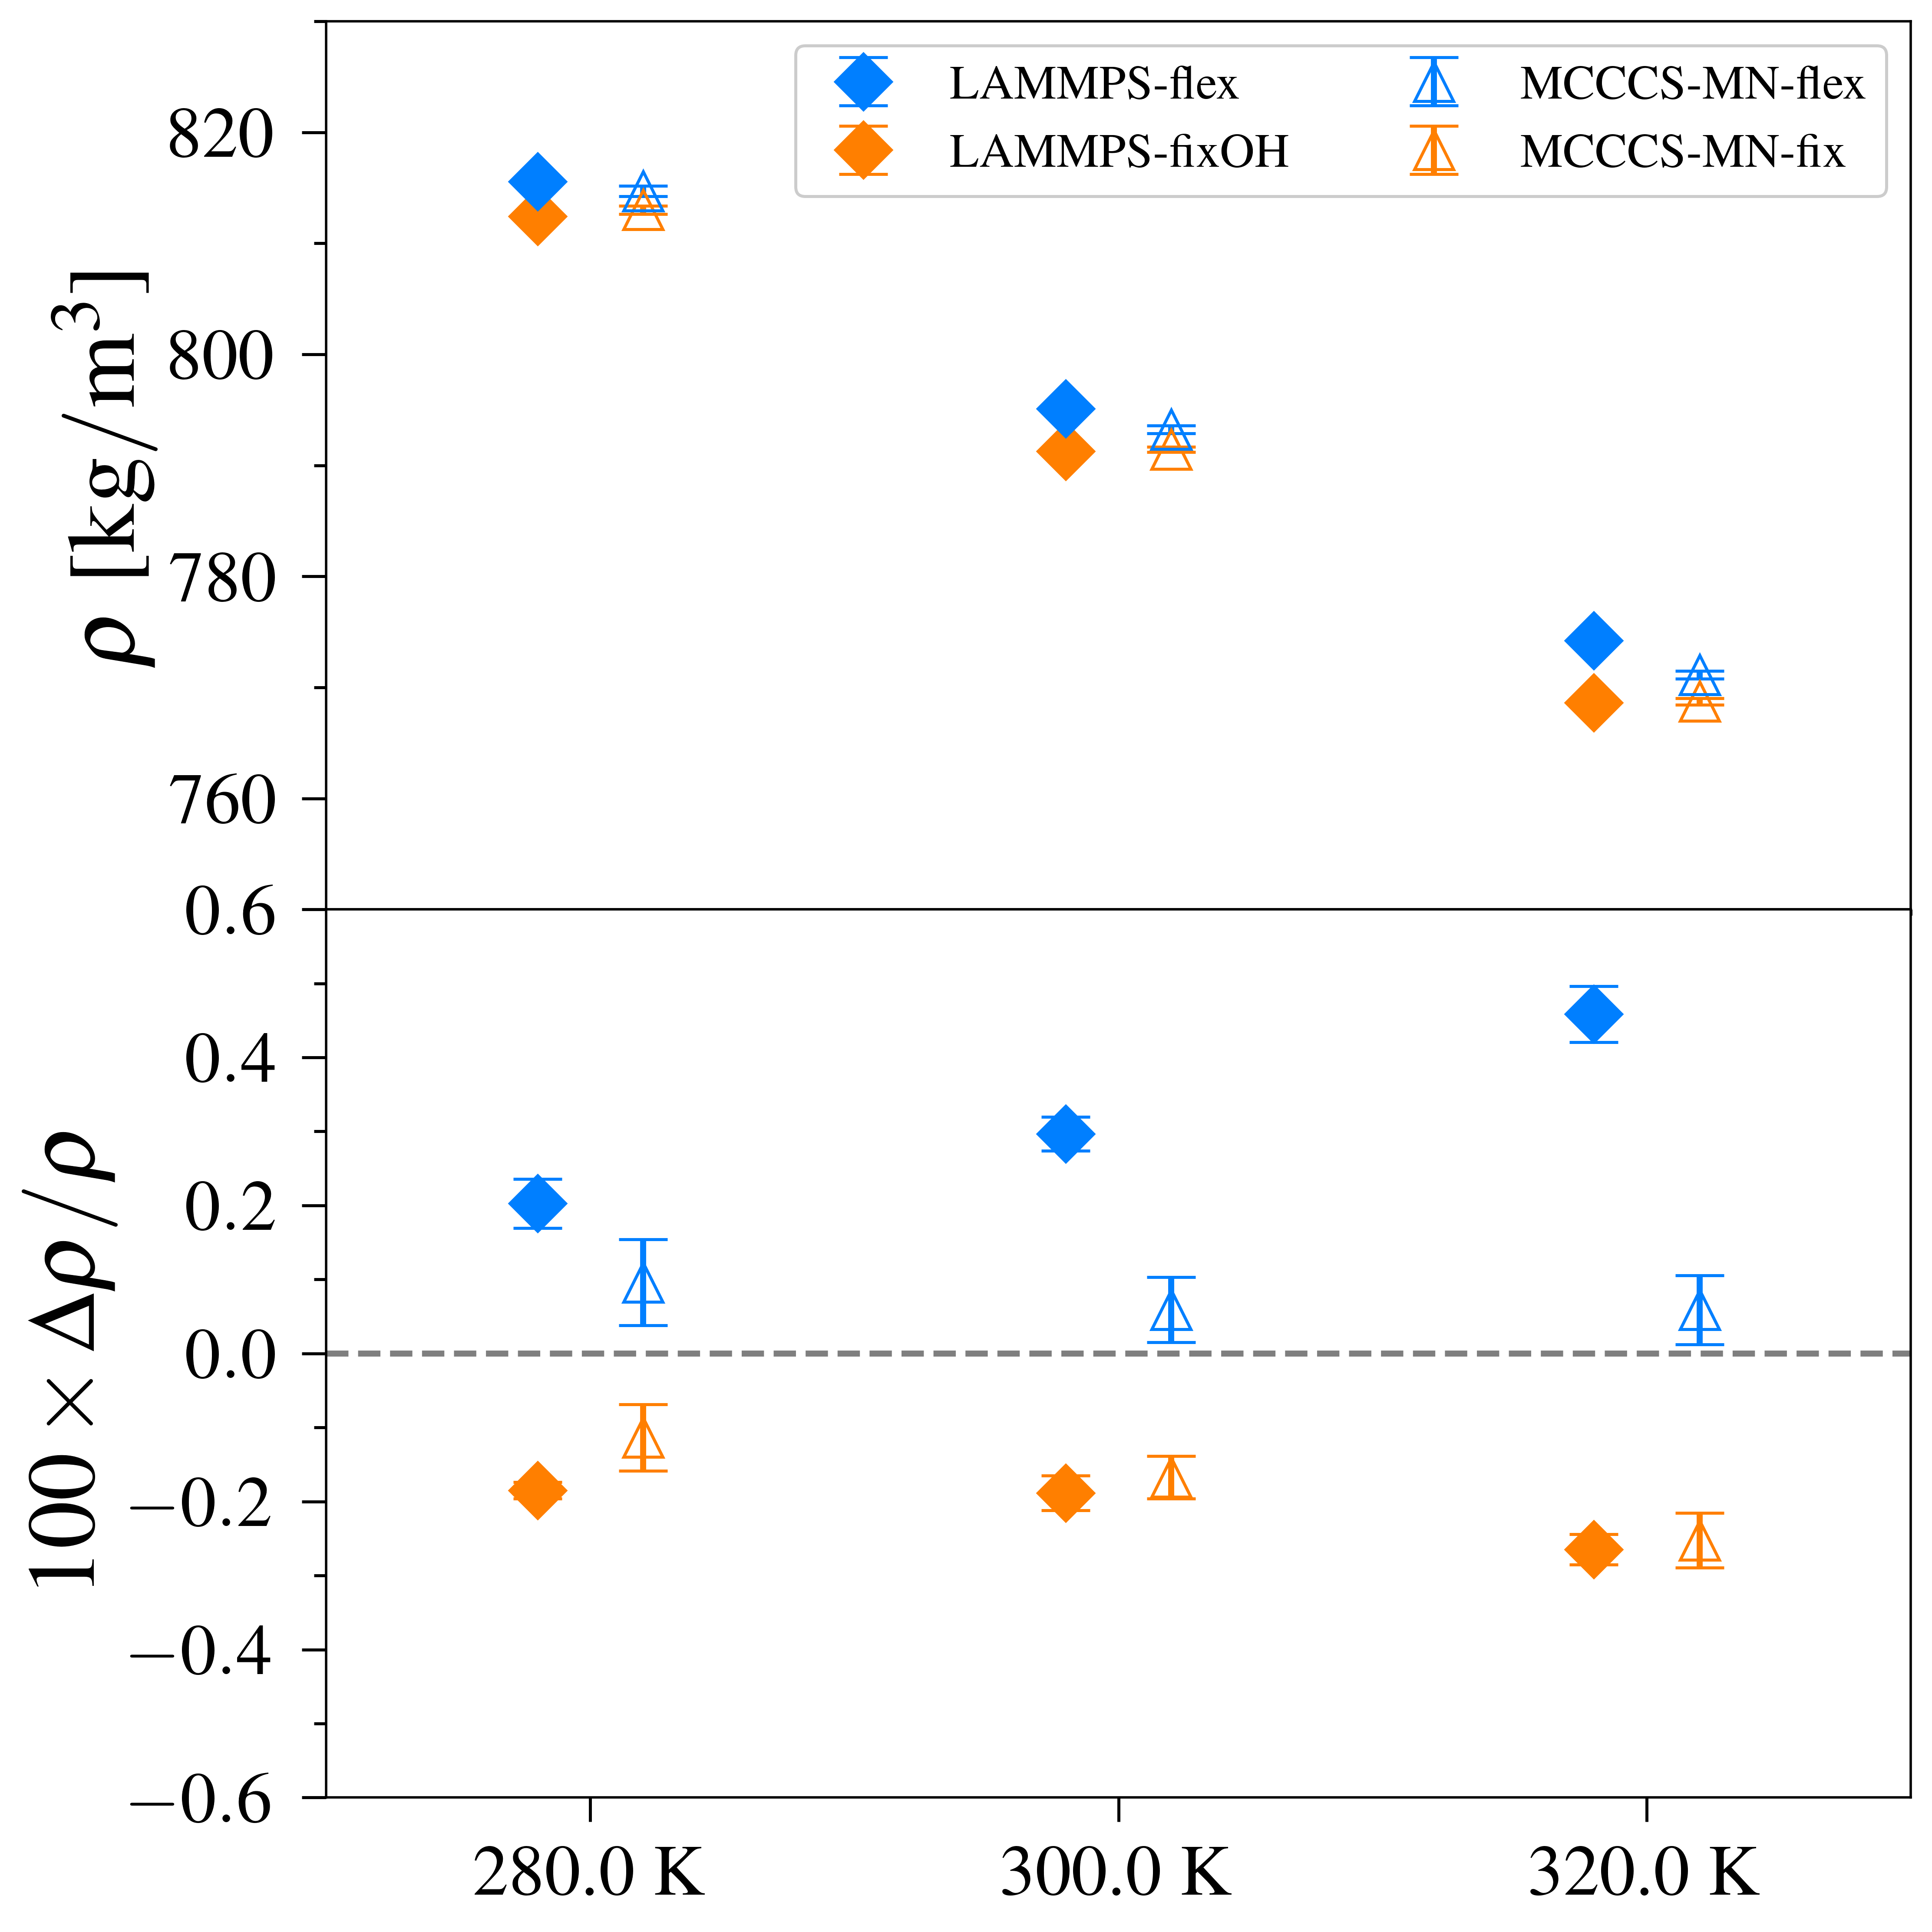

In [11]:
molecule = "ethanolAA"
engines = ["lammps-VU", "mcccs"]
 
figsize=(9, 9)
fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(2, hspace=0)
ax = gs.subplots(sharex=True, sharey=False)

try:
    mol_group = summary_df.groupby(group_key)
    mol_df = mol_group.get_group(molecule)
except KeyError:
    print(f"skipping: {molecule}, no data available.")


mol_df["statepoint"] = (
    summary_df["temperature"].map(str)
    + " K "
    )

statepoints = sorted(set(mol_df["statepoint"]))
statepoints_overall_means = list()

xticks = list()
sps_positions = list()
for n_statepoint, statepoint in enumerate(statepoints):
    # print(statepoint)
    densities = list() 
    stds = list()
    sems = list()
    for engine in engines:
        for bcond in ["fix", "flex"]:
            shortlisted = mol_df[
                (mol_df["engine"] == engine) 
                & (mol_df["statepoint"] == statepoint)
                & (mol_df["ensemble"] == f"NPT-{bcond}OH")]
            densities.append(shortlisted["density-avg"]*1000)
            stds.append(shortlisted["density-std"]*1000)
            sems.append(shortlisted["density-sem"]*1000)

    densities = [density for density in densities if density.values]
    overall_mean = np.mean(densities) 
    statepoints_overall_means.append(overall_mean) 
    
    confidence_interval = mean_confidence_interval(densities, np.array(sems), confidence=0.95)
    percentage_delta_density = (densities-overall_mean) * 100 / overall_mean
    percentage_sem_density = 100 * np.array(sems) / overall_mean
    percentage_ci_density = 100 * np.array(confidence_interval) / overall_mean

    sp_position = list()
    counts = 0
    space_scaling = 2
    for i, engine in enumerate(engines):
        for j, bcond in enumerate(["fix", "flex"]): 
            print(engine, bcond)
            print(float(densities[counts]), float(confidence_interval[counts]))
            print(float(percentage_delta_density[counts]), float(percentage_ci_density[counts]))
            spacing = space_scaling *  n_statepoint + space_scaling/5*i
            sp_position.append(spacing)
            ax[0].errorbar(
                spacing, 
                densities[counts],
                marker=symbols[engine], 
                yerr=confidence_interval[counts], 
                color=colors[bcond], 
                fillstyle=fill_styles[engine],
                ls='',
                label=engine+bcond,
            )
            ax[1].errorbar(
                spacing, 
                percentage_delta_density[counts],
                marker=symbols[engine], 
                yerr=percentage_ci_density[counts], 
                color=colors[bcond], 
                fillstyle=fill_styles[engine],
                ls='',
                label=engine+bcond,
            )                
            counts +=1

            

    xticks.append(statepoint+r'$\rho_{\mathrm{ave}}$'+r'$ = {:.3f}$'.format(overall_mean))
    sps_positions.append(np.mean(sp_position))

ax[1].axhline(y = 0, color = 'black', alpha=0.5, linestyle = '--')

#ax[1].set_xlabel("State point")
ax[1].set_ylabel(r"${100\times\Delta\rho}/{\rho}$")
ax[0].set_ylabel(r"$\rho$ [$\mathrm{{kg}/{m^3}}$]")

ax[0].tick_params(axis='y')
#plt.title(f"{molecule}")
props = dict(boxstyle='round', facecolor='none',alpha=1, ec ='grey')
#string+='{:.5f}'.format(overall_mean)

ax[0].set_xticks([pos for pos in sps_positions])    
if len(statepoints) != 1:
    # ax[0].set_xticklabels([
    #     f'{sp}\n' +r'$\rho_{\mathrm{ave}}$'+'$ = {:.3f}$'.format(sp_omean) 
    #     for sp_omean, sp in zip(statepoints_overall_means, statepoints)
    #     ]
    # )
    ax[0].set_xticklabels([statepoint for statepoint in statepoints])

    ax[0].set_xlim(sps_positions[0]-1, sps_positions[-1]+1)
    ax[1].set_xlim(sps_positions[0]-1, sps_positions[-1]+1)
else:
    plt.xticks([])


# Handle ylim 
low, high = ax[1].get_ylim()
bound = max(abs(low), abs(high))
#ax1.set_ylim(-bound*1.1, bound*1.1) 
ax[0].set_ylim(750, 830)
ax[1].set_ylim(-0.6, 0.6)

# get handles
#wrap_labels(ax, 10)
handles, labels = ax[0].get_legend_handles_labels()

#Sorting handles and labels: 
labels_handles = dict()
for handle, label in zip(handles, labels):
    labels_handles[label] = handle

sorted_handles = [labels_handles[engine+bcond] 
                  for engine, bcond in itertools.product(engines, ["flex", "fix"])]
sorted_labels = [pretty_names[engine+bcond] 
                 for engine, bcond in itertools.product(engines, ["flex", "fix"])]

# plt.legend(sorted_handles, 
#            sorted_labels,
#            bbox_to_anchor=(1.05, 0.4),
#            bbox_transform=fig.transFigure,
#            labelspacing=2,
#            facecolor='white', 
#            loc='lower right',
#            prop={'size': 12},
#            ncol=1)


ax[0].legend(
           sorted_handles, 
           sorted_labels,
           #bbox_to_anchor=(0.6, 1.09),
           #bbox_transform=fig.transFigure,
           #labelspacing=2,
           facecolor='white', 
           loc="best", # 'upper center',
           prop={'size': 16},
           ncol=2
)
    
    
for i in range(2):
    ax[i].tick_params(which='both', width=1)
    ax[i].tick_params(which="major", length=8, axis="y", bottom=False)
    ax[i].tick_params(which="minor", length=4, axis="y", bottom=False)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

            
ax[1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    ) # labels along the bottom edge are off
ax[1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    length=8
    ) # labels along the bottom edge are off

        
plt.tight_layout()
ax[0].grid(alpha = 0., axis='x')
ax[1].grid(alpha = 0., axis='x')
plt.savefig(f'figures/ethanol_stacked_deviation_density.pdf', dpi=500, bbox_inches="tight")

plt.show()
plt.close()
